In [2]:
import os
import typing

from sklearn.gaussian_process.kernels import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt
from matplotlib import cm

In [7]:
# Load the training dateset and test features
train_x = np.loadtxt("train_x.csv", delimiter=",", skiprows=1)
train_y = np.loadtxt("train_y.csv", delimiter=",", skiprows=1)
test_x = np.loadtxt("test_x.csv", delimiter=",", skiprows=1)

In [8]:
# Set `EXTENDED_EVALUATION` to `True` in order to visualize your predictions.
EXTENDED_EVALUATION = False
EVALUATION_GRID_POINTS = 300  # Number of grid points used in extended evaluation
EVALUATION_GRID_POINTS_3D = 50  # Number of points displayed in 3D during evaluation


# Cost function constants
THRESHOLD = 35.5
COST_W_NORMAL = 1.0
COST_W_OVERPREDICT = 5.0
COST_W_THRESHOLD = 20.0


class Model(object):
    """
    Model for this task.
    You need to implement the fit_model and predict methods
    without changing their signatures, but are allowed to create additional methods.
    """

    def __init__(self):
        """
        Initialize your model here.
        We already provide a random number generator for reproducibility.
        """
        self.rng = np.random.default_rng(seed=0)

        # TODO: Add custom initialization for your model here if necessary
        self.kernel = DotProduct() + WhiteKernel()
        self.gpm = GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=3,
            normalize_y=True,
            random_state=self.rng.integers(low=0, high=10, size=1)[0],
        )
        self.feature_map_nystroem = Nystroem(gamma=0.2, random_state=9, n_components=20)

    def predict(
        self, x: np.ndarray
    ) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict the pollution concentration for a given set of locations.
        :param x: Locations as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :return:
            Tuple of three 1d NumPy float arrays, each of shape (NUM_SAMPLES,),
            containing your predictions, the GP posterior mean, and the GP posterior stddev (in that order)
        """

        # x_test_transformed = self.feature_map_nystroem.fit_transform(x)
        # TODO: Use your GP to estimate the posterior mean and stddev for each location here
        gp_mean, gp_std = self.gpm.predict(x, return_std=True)

        # TODO: Use the GP posterior to form your predictions here
        predictions = gp_mean

        return predictions, gp_mean, gp_std

    def fit_model(self, train_x: np.ndarray, train_y: np.ndarray):
        """
        Fit your model on the given training data.
        :param train_x: Training features as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :param train_y: Training pollution concentrations as a 1d NumPy float array of shape (NUM_SAMPLES,)
        """

        random_subset = self.rng.integers(
            low=0, high=len(train_y), size=int(0.5 * len(train_y))
        )

        # x_transformed = self.feature_map_nystroem.fit_transform(train_x)
        self.gpm.fit(train_x[random_subset], train_y[random_subset])


def cost_function(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    """
    Calculates the cost of a set of predictions.

    :param y_true: Ground truth pollution levels as a 1d NumPy float array
    :param y_predicted: Predicted pollution levels as a 1d NumPy float array
    :return: Total cost of all predictions as a single float
    """
    assert (
        y_true.ndim == 1 and y_predicted.ndim == 1 and y_true.shape == y_predicted.shape
    )

    # Unweighted cost
    cost = (y_true - y_predicted) ** 2
    weights = np.zeros_like(cost)

    # Case i): overprediction
    mask_1 = y_predicted > y_true
    weights[mask_1] = COST_W_OVERPREDICT

    # Case ii): true is above threshold, prediction below
    mask_2 = (y_true >= THRESHOLD) & (y_predicted < THRESHOLD)
    weights[mask_2] = COST_W_THRESHOLD

    # Case iii): everything else
    mask_3 = ~(mask_1 | mask_2)
    weights[mask_3] = COST_W_NORMAL

    # Weigh the cost and return the average
    return np.mean(cost * weights)


def perform_extended_evaluation(model: Model, output_dir: str = "/results"):
    """
    Visualizes the predictions of a fitted model.
    :param model: Fitted model to be visualized
    :param output_dir: Directory in which the visualizations will be stored
    """
    print("Performing extended evaluation")
    fig = plt.figure(figsize=(30, 10))
    fig.suptitle("Extended visualization of task 1")

    # Visualize on a uniform grid over the entire coordinate system
    grid_lat, grid_lon = np.meshgrid(
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS)
        / EVALUATION_GRID_POINTS,
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS)
        / EVALUATION_GRID_POINTS,
    )
    visualization_xs = np.stack((grid_lon.flatten(), grid_lat.flatten()), axis=1)

    # Obtain predictions, means, and stddevs over the entire map
    predictions, gp_mean, gp_stddev = model.predict(visualization_xs)
    predictions = np.reshape(
        predictions, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS)
    )
    gp_mean = np.reshape(gp_mean, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))
    gp_stddev = np.reshape(gp_stddev, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))

    vmin, vmax = 0.0, 65.0
    vmax_stddev = 35.5

    # Plot the actual predictions
    ax_predictions = fig.add_subplot(1, 3, 1)
    predictions_plot = ax_predictions.imshow(predictions, vmin=vmin, vmax=vmax)
    ax_predictions.set_title("Predictions")
    fig.colorbar(predictions_plot)

    # Plot the raw GP predictions with their stddeviations
    ax_gp = fig.add_subplot(1, 3, 2, projection="3d")
    ax_gp.plot_surface(
        X=grid_lon,
        Y=grid_lat,
        Z=gp_mean,
        facecolors=cm.get_cmap()(gp_stddev / vmax_stddev),
        rcount=EVALUATION_GRID_POINTS_3D,
        ccount=EVALUATION_GRID_POINTS_3D,
        linewidth=0,
        antialiased=False,
    )
    ax_gp.set_zlim(vmin, vmax)
    ax_gp.set_title("GP means, colors are GP stddev")

    # Plot the standard deviations
    ax_stddev = fig.add_subplot(1, 3, 3)
    stddev_plot = ax_stddev.imshow(gp_stddev, vmin=vmin, vmax=vmax_stddev)
    ax_stddev.set_title("GP estimated stddev")
    fig.colorbar(stddev_plot)

    # Save figure to pdf
    figure_path = os.path.join(output_dir, "extended_evaluation.pdf")
    fig.savefig(figure_path)
    print(f"Saved extended evaluation to {figure_path}")

    plt.show()

In [10]:
model = Model()
model.fit_model(train_x, train_y)

In [11]:
predicted_y = model.predict(test_x)

Performing extended evaluation
Saved extended evaluation to ./extended_evaluation.pdf


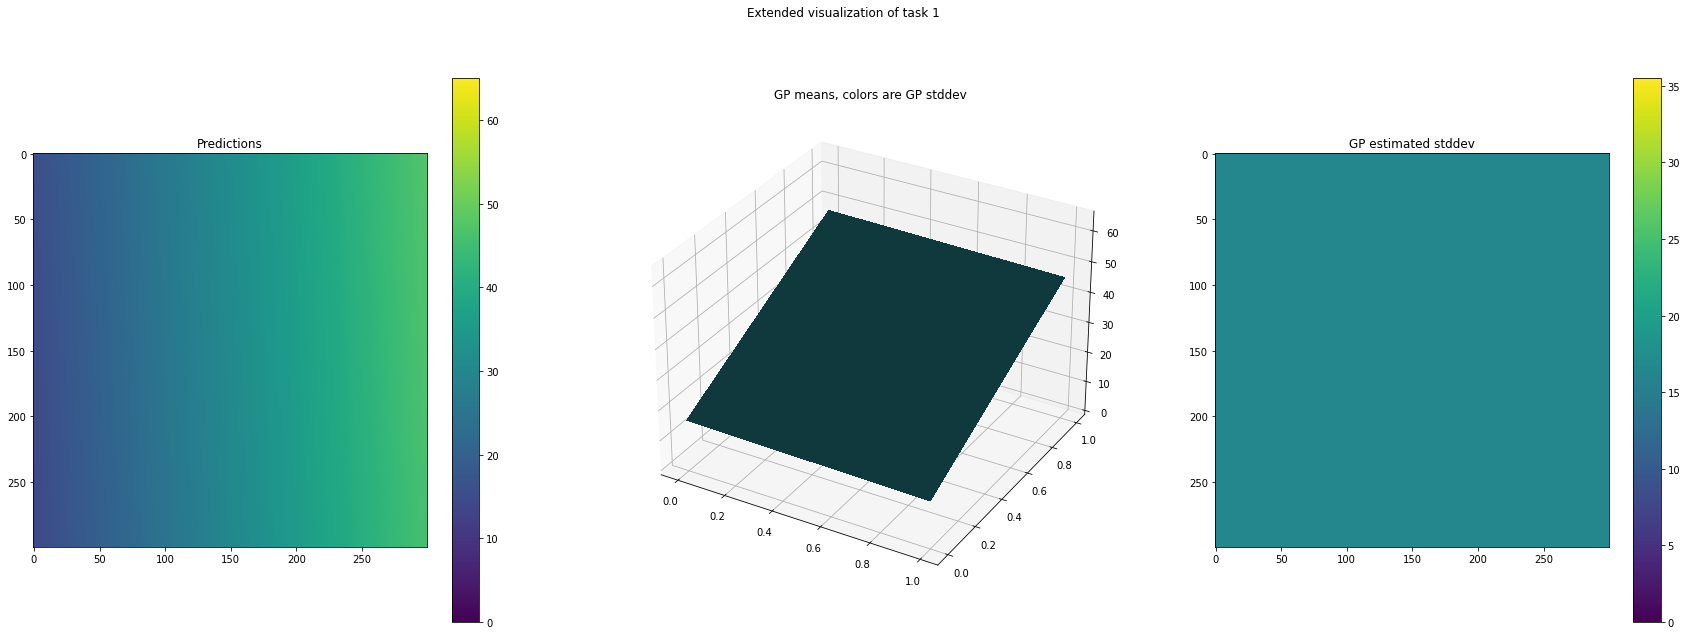

In [12]:
perform_extended_evaluation(model, output_dir=".")

In [18]:
np.median(predicted_y[0])

35.45205055830313

In [47]:
import pandas as pd

In [59]:
train_data = pd.DataFrame(train_x, columns=["Lat", "Long"])
train_data["y"] = train_y
train_data

,Lat,Long,y
0,0.85750,0.68625,36.203168
1,0.41125,0.67500,55.946348
2,0.86250,0.90625,12.042066
3,0.81125,0.81000,48.804589
4,0.46875,0.11625,11.136404
...,...,...,...
15184,0.39500,0.52375,28.158460
15185,0.29000,0.48125,36.928889
15186,0.13500,0.64000,36.641309
15187,0.07125,0.78875,18.662634


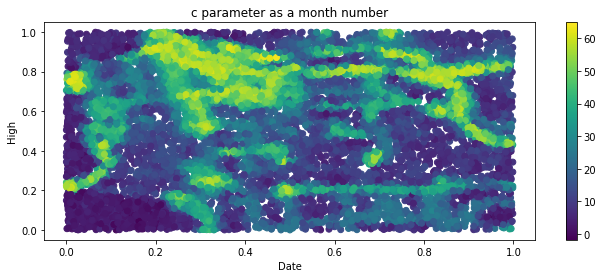

In [63]:
fig, ax = plt.subplots(figsize=(11, 4))
sc = ax.scatter(data=train_data, x="Lat", y="Long", c=train_data.y)
ax.set(title='c parameter as a month number', xlabel='Date', ylabel='High')
plt.colorbar(sc)
plt.show()

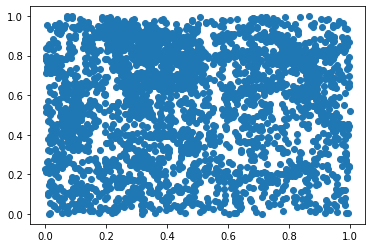

In [68]:
test_data = pd.DataFrame(test_x, columns=["Lat", "Long"])
plt.scatter(test_data["Lat"], test_data["Long"])
plt.show()

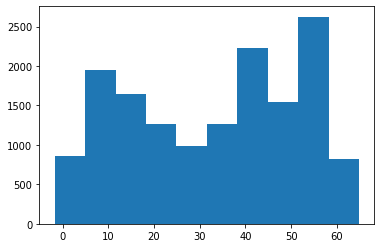

In [46]:
plt.hist(train_y)
plt.show()

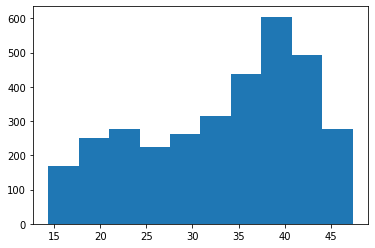

In [45]:
plt.hist(predicted_y[0])
plt.show()

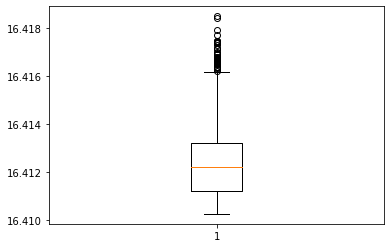

In [21]:
plt.boxplot(predicted_y[2])
plt.show()